# bRawL Project Tools

This notebook will walk you through some of the gym, rllib and sacred basics. These are all tools we will be using throughout this project, so it's best to get a solid working familiarity with them from the getgo

In [1]:
# Begin with some imports
import torch
import ray
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Let's verify that torch can see our GPUs

In [2]:
# Should return `True`
torch.cuda.is_available()

True

## Environments

The central mathematical object that underpins all reinforcement learning is the Markov Decision Process (MDP). As you learned, the MDP can be represented as a four tuple $(\mathcal{S}, \mathcal{A}, \mathcal{T}, R)$, where $\mathcal{S}$ is the state space, $\mathcal{A}$ is the action space, $\mathcal{T} : \mathcal{S} x \mathcal{A} \longrightarrow \mathcal{S}$ is the transition function that encodes the state dynamics, and $\mathcal{R} : \mathcal{S} x \mathcal{A} \longrightarrow \mathbb{R}$ is the reward function

In practice, we represent such an object using an environment class, usually one that follows the [gym](https://gym.openai.com/) API. The `Environment` class has the following core functions that all subclasses must implement:

`step(action)`:  

Takes in an action and returns a tuple `(observation, reward, done, info)` where `observation` is the new state we arrive at, `reward` is a scalar represeting how much reward the agent got at this timestep, `done` is a boolean indicating whether the current episode has terminated, and `info` is reserved for whatever metadata  

`reset()`:  

Called at the beginning of every episode, used to instantiate all agents and environment artifacts, returns initial state observation. 

In addition, the `Environment` class has `observation_space` and `action_space` members that represent the set of allowable states and actions. Environments can be created by calling `gym.make('<environment_name>')`



Let's look at a specific example below, the classic Atari game, Breakout

In [3]:
breakout_env = gym.make('Breakout-v0')

ob_space = breakout_env.observation_space
ac_space = breakout_env.action_space

initial_state = breakout_env.reset()

print("Observation space", ob_space)
print("Action space", ac_space)
print("Initial state shape", initial_state.shape)

Observation space Box(0, 255, (210, 160, 3), uint8)
Action space Discrete(4)
Initial state shape (210, 160, 3)


Let's see if we can visualize a state of the environment

Render shape (210, 160, 3)


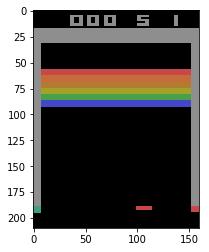

In [4]:
img = breakout_env.render(mode='rgb_array')
print("Render shape", img.shape)
plt.imshow(breakout_env.render(mode='rgb_array'))

As you can see, the `observation` array is precisely a RGB image representing the pixels on the game

Now let's visualize a rollout generated by randomly sampling actions at every timestep

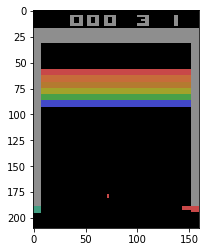

In [5]:
breakout_env.reset()
for _ in range(100):
    plt.imshow(breakout_env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = breakout_env.action_space.sample()
    breakout_env.step(action)

Oof. That was... not great....

But do not despair, this is where the RL comes in. Our agents will learn to behave intelligently by the end of this if all goes according to plan. 

## Rllib 

### Policies

Now let's get a sense of some of the inner workings of Rllib, the library we'll be using to train our agents. The key abstraction in rllib is the `Policy` object. The policy represents a function that accepts an input state, and outputs a distribution over possible actions the agent should take at this state. 

The policy class takes in an `observation_space` and `action_space` as parameters, and implements the function `compute_actions`, `learn_on_batch` and `compute_log_likelihoods`

To get a sense of how policies work, let's see if we can implement our random policy from above

In [3]:
from ray.rllib.policy.policy import Policy

class RandomPolicy(Policy):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # TODO: Set some instance variables here
        # Note: the super constructor will set the instance variables `action_space` and `observation_space` for you
        pass
    
    def compute_actions(self,
                        obs_batch,
                        state_batches=None,
                        prev_action_batch=None,
                        prev_reward_batch=None,
                        **kwargs):
        # Randomly sample an action
        pass
    
    def learn_on_batch(self, samples):
        """No learning."""
        return {}
    
    def compute_log_likelihoods(self,
                                actions,
                                obs_batch,
                                state_batches=None,
                                prev_action_batch=None,
                                prev_reward_batch=None):
        # Return logits from a uniform distribution
        pass
    def get_weights(self):
        """
        No-op to keep rllib from breaking, won't be necessary in future rllib releases
        """
        pass

    def set_weights(self, weights):
        """
        No-op to keep rllib from breaking
        """
        pass

Instructions for updating:
non-resource variables are not supported in the long term


In [26]:
from ray.rllib.env.multi_agent_env import MultiAgentEnv
class BreakoutRllib(MultiAgentEnv):
    
    def __init__(self, *args, **kwargs):
        self._env = gym.make('Breakout-v0')
        self.action_space = self._env.action_space
        self.observation_space = self._env.observation_space
        
        
    def step(self, action):
        obs, reward, done, info = self._env.step(action)
        return { "random" : obs }, reward, done, info
    
    def reset(self):
        return self._env.reset()

In [28]:
# Some ray setup
from ray.rllib.agents.ppo.ppo import PPOTrainer
from ray.tune.registry import register_env
ray.init()

# Register the gym environment (Note that this is different than the gym registry!)
register_env("breakout",
             lambda _: BreakoutRllib())
obs_space = breakout_env.observation_space
act_space = breakout_env.action_space

config = config={
        "multiagent": {
            "policies": {
                "random": (RandomPolicy, obs_space, act_space, {}),
            },
            "policy_mapping_fn": (
                lambda agent_id: "random"),
        },
        "num_workers" : 1,
        "framework": "torch"
}

trainer = PPOTrainer(env="breakout", config=config)

2020-09-27 20:24:31,322	INFO resource_spec.py:231 -- Starting Ray with 1.51 GiB memory available for workers and up to 0.78 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-09-27 20:24:31,769	INFO services.py:1193 -- View the Ray dashboard at localhost:8265
2020-09-27 20:24:31,775	WARNING services.py:1567 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67084288 bytes available. This may slow down performance! You may be able to free up space by deleting files in /dev/shm or terminating any running plasma_store_server processes. If you are inside a Docker container, you may need to pass an argument with the flag '--shm-size' to 'docker run'.
2020-09-27 20:24:31,794	WARNING services.py:1567 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67084288 bytes available. This may slow down performance! You may be able to free up space by deleting files 

In [27]:
ray.shutdown()

### Custom Models

### Callbacks

## Sacred

Another useful tool we will be using is sacred. It offers us two conviences: syntatic sugar for command line calls, as well as automated slack notifications for when trainings complete. The api is simple:

In [30]:
# Create an experiment object
from sacred import Experiment
ex = Experiment("My Experiment", interactive=True)

In [35]:
@ex.config
def my_config():
    # Define any parameters and its defaults here
    
    a = 1
    b = 2
    c = 3
    
    params = {
        "a" : a,
        "b" : b,
        "c" : c
    }

In [36]:
@ex.main
def main(params):
    for (key, value) in params.items():
        print("Parameter {} is set to {}".format(key, value))

In [37]:
ex.run()

WARNING - My Experiment - No observers have been added to this run
INFO - My Experiment - Running command 'main'
INFO - My Experiment - Started
INFO - My Experiment - Completed after 0:00:00


Parameter a is set to 1
Parameter b is set to 2
Parameter c is set to 3


As you can see, the `params` defined in `my_config` was passed into `main` when we ran the experiment. We can override defualt values in python using the following syntax

In [38]:
ex.run(config_updates={'c' : 'this is a non-default setting!'})

WARNING - root - Changed type of config entry "c" from int to str
WARNING - My Experiment - No observers have been added to this run
INFO - My Experiment - Running command 'main'
INFO - My Experiment - Started
INFO - My Experiment - Completed after 0:00:00


Parameter a is set to 1
Parameter b is set to 2
Parameter c is set to this is a non-default setting!


As you can see, the value of `c` was updated, and sacred even gave us a type warning, a true luxury in the python world!

If saved all the above code in a file called `foo.py` we could run the experiment from the command line by executing 
```
python foo.py 
```

In order to update `c` as we did in the second run, we would execute
```
python foo.py with c="this is a non-default setting!"
```

The general syntax for upating any param is
```
python foo.py with <param_1>=<val_1> <param_2>=<val_2>...
```